In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
import numpy as np
import xarray as xr

# Input Fields

## Ocean

### GLBv0.08

- 3 hr
- 0.08 degree

In [2]:
glb_url = 'http://tds.hycom.org/thredds/dodsC/GLBv0.08/expt_56.3'

In [3]:
glb_ds = xr.open_dataset(glb_url, decode_times=False)

In [4]:
# June 1, 00:00 = 135120., July 1, 00:00 = 135840.
glb_ds = glb_ds.sel(depth=0.0, lat = slice(47., 49.), lon = slice(-51., -49.), time=slice(135120., 135840.))

In [5]:
water_u = glb_ds.water_u
water_v = glb_ds.water_v
water_temp = glb_ds.water_temp

In [6]:
glb_times = np.asarray(water_u.time)
glb_lats = np.asarray(water_u.lat)
glb_lons = np.asarray(water_u.lon)

In [7]:
glb_times = glb_times - 135120

In [8]:
water_u = np.asarray(water_u)
water_v = np.asarray(water_v)
water_temp = np.asarray(water_temp)

## Atmosphere

### NAVGEM

- 6 hr
- 0.08 degree

In [9]:
navgem_url = 'http://coastwatch.pfeg.noaa.gov/erddap/griddap/erdNavgem05D10mWind_LonPM180'

In [10]:
navgem_ds = xr.open_dataset(navgem_url)

In [11]:
navgem_ds = navgem_ds.sel(time=slice('2015-06-01','2015-07-01'), latitude=slice(47,49), longitude=slice(-51,-49))

In [12]:
wind_u = navgem_ds.wnd_ucmp_height_above_ground
wind_v = navgem_ds.wnd_vcmp_height_above_ground

In [13]:
#navgem_times = np.asarray(wind_u.time)
navgem_times = np.linspace(0, 120*6 - 6, 120)
navgem_lats = np.asarray(wind_u.latitude)
navgem_lons = np.asarray(wind_u.longitude)

In [16]:
wind_u = np.asarray(wind_u)
wind_v = np.asarray(wind_v)

# Tools

In [17]:
bob = np.asarray([2.1, 2.3, 2.2])

In [18]:
jim = abs(bob-2.16)

In [19]:
jim

array([ 0.06,  0.14,  0.04])

In [20]:
np.argpartition(jim, 2)[2]

1

In [21]:
def find_nearest(val, arr):
    diff_arr = abs(arr - val)
    smallest_ind = np.argpartition(diff_arr, 0)[0]
    smallest_val = arr[smallest_ind]
    next_smallest_ind = np.argpartition(diff_arr, 1)[1]
    next_smallest_val = arr[next_smallest_ind]
    return smallest_ind, smallest_val, next_smallest_ind, next_smallest_val       

In [22]:
def linear_interp_1D(x, x1, x2):  
    xi1 = (x2 - x)/(x2 - x1)
    xi2 = (x - x1)/(x2 - x1)
    xi = x1*xi1 + x2*xi2
    return xi

In [23]:
t = 50.2
t_atm_ind1, t_atm_val1, t_atm_ind2, t_atm_val2 = find_nearest(t, navgem_lats)


In [24]:
t_atm_val2

48.499992

# Model

In [25]:
import scipy.io as sio
import numpy.matlib
import cmath

In [26]:
# Constants
R = 6378*1e3
om = 7.2921e-5
rhow = 1027
rhoa = 1.2
rhoi = 850
drho = rhow - rhoi
Cw = 0.9
Ca = 1.3
gam = np.sqrt(rhoa*drho/rhow/rhoi*(Ca/Cw))
sst0 = -4
Cs1 = 1.5; Cs2 = 0.5; Cs3 = 0.1
CMv1 = 7.62e-3; CMv2 = 1.29e-3; CMe1 = 0.5
CMb1 = 0.58; CMb2 = 0.8; CMb3 = 0.2

In [45]:
# Timesteps
t0 = 0  # initial time
t_inc = 3  # 3 hr
num_days = 30
tn = t_inc * num_days  # total number of timesteps
dt = 1*3*3600  # model timestep in seconds
tf = t0 + tn*dt  # final timestep in seconds  
t_all = np.arange(t0, tn, t_inc)

In [46]:
t_all

array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48,
       51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87])

In [39]:
# Iceberg Inits
x0, y0 = -50, 48   # lon, lat
l0, w0, h0 = 600, 500, 400   # length, width, height


timestep: 0

vau =  14.5
vav =  3.4
vwu =  0.210000009974
vwv =  -0.15600000741
sst =  3.81999923149
S = 856.797996433580010
ff = 0.000108381727637
lam = 3.826895003296125
alpha = -0.345173069648729
0.9027192022845002
beta = 0.9027192022845002
viu = 0.477389531960739
viv = -0.192289887146324
x_new = -49.930793743740047
y_new = 47.981344009258933
Me = 3.639050974158986
Mv = 0.047932582569849
Mb = 0.442476975060508
l_new = 599.539127055408926
w_new = 499.539127055408869
h_new = 399.944690378117457

timestep: 1

vau =  14.5
vav =  3.4
vwu =  0.210000009974
vwv =  -0.15600000741
sst =  3.81999923149
S = 856.068070932689807
ff = 0.000108349946627
lam = 3.831281456143775
alpha = -0.344831634839030
0.9029303296685476
beta = 0.9029303296685476
viu = 0.477425160149754
viv = -0.192183616897165
x_new = -49.861607323289554
y_new = 47.962698328871745
Me = 3.639050974158986
Mv = 0.047932582569849
Mb = 0.442572579830856
l_new = 599.078254110817852
w_new = 499.078254110817738
h_new = 399.889368805638

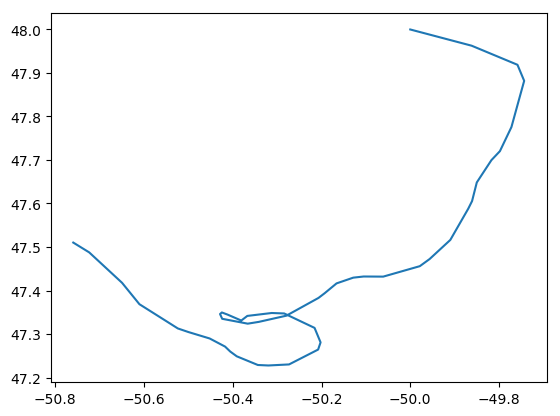

In [48]:
def main():

    x, y = x0, y0
    l, w, h = l0, w0, h0
    t = t0
    iceberg = np.array([[t0],[x0],[y0],[l0],[w0],[h0]])

    while t < max(t_all):

        x_new, y_new, l_new, w_new, h_new = iceDEF(t, x, y, l, w, h)

        
        if x_new > -49 or x_new < -51 or y_new > 49 or y_new < 47:
            # Iceberg out-of-bounds
            print(x_new)
            print(y_new)
            print('out-of-bounds')
            break
        

        if l_new <= 0 or w_new <= 0 or h_new <= 0:
            # Iceberg melted
            print('melted')
            break

        else:
            x, y, l, w, h = x_new, y_new, l_new, w_new, h_new
            t += 1
            iceberg_new = np.array([[t],[x],[y],[l],[w],[h]])
            iceberg = np.column_stack((iceberg, iceberg_new))

            
    plt.plot(iceberg[1,:],iceberg[2,:])

        
    save_dict = {
                    't_arr': iceberg[0,:],
                    'x_arr': iceberg[1,:],
                    'y_arr': iceberg[2,:],
                    'l_arr': iceberg[3,:],
                    'w_arr': iceberg[4,:],
                    'h_arr': iceberg[5,:]
                }

    plt.plot
    

def iceDEF(t,x,y,l,w,h):

    print('\ntimestep: {}\n'.format(t))
    

    # Atmosphere

    t_atm_ind1, t_atm_val1, t_atm_ind2, t_atm_val2 = find_nearest(t, navgem_times)
    x_atm_ind1, x_atm_val1, x_atm_ind2, x_atm_val2 = find_nearest(t, navgem_lons)
    y_atm_ind1, y_atm_val1, y_atm_ind2, y_atm_val2 = find_nearest(t, navgem_lats)
    
    #(t, height, lat, lon)
    vau = wind_u[t_atm_ind1, 0, y_atm_ind1, x_atm_ind1] 
    vav = wind_v[t_atm_ind1, 0, y_atm_ind1, x_atm_ind1] 

    
    # Ocean
    
    t_ocean_ind1, t_ocean_val1, t_ocean_ind2, t_ocean_val2 = find_nearest(t, glb_times)
    x_ocean_ind1, x_ocean_val1, x_ocean_ind2, x_ocean_val2 = find_nearest(t, glb_lons)
    y_ocean_ind1, y_ocean_val1, y_ocean_ind2, y_ocean_val2 = find_nearest(t, glb_lats)
    
    #(t, lat, lon)
    vwu = water_u[t_ocean_ind1, y_ocean_ind1, x_ocean_ind1] 
    vwv = water_v[t_ocean_ind1, y_ocean_ind1, x_ocean_ind1] 
    sst = water_temp[t_ocean_ind1, y_ocean_ind1, x_ocean_ind1] 

    print('vau = ', vau)
    print('vav = ', vav)
    print('vwu = ', vwu)
    print('vwv = ', vwv)
    print('sst = ', sst)
    

    # Drifting

    S = np.pi*((l*w)/(l+w))
    ff = 2*om*np.sin((np.abs(y)*np.pi)/180)
    lam = np.sqrt(2)*Cw*(gam*np.sqrt(vau**2 + vav**2))/(ff*S)
    print('S = {0:.15f}'.format(S))
    print('ff = {0:.15f}'.format(ff))
    print('lam = {0:.15f}'.format(lam))
    
    if lam < 0.1:
        print('Taylor approx used for alpha')
        alpha = lam*(lam**4*(lam**4*(lam**4*(-0.0386699020961393*lam**4 + \
            0.055242717280199) - 0.0883883476483184) + \
            0.176776695296637) - 0.707106781186548)
    else:
        alpha = np.multiply(np.divide(np.sqrt(2),np.power(lam, 3)),(1-np.sqrt(1+np.power(lam,4))))
        
    if lam < 0.6:
        print('Taylor approx used for beta')
        beta = lam**3*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*(lam**4*\
            (0.0153268598203613*lam**4 - 0.0151656272365985) + \
            0.0180267866272764) + 0.0219176256311202) - \
            0.0274446790511418) + 0.0357675015202851) - \
            0.0493731785691779) + 0.0745776683282687) - \
            0.132582521472478) + 0.353553390593274)
    else:
        beta = np.real(np.multiply(np.divide(1.,np.power(lam,3.)),cmath.sqrt(np.multiply((4.+np.power(lam,4.)), \
            cmath.sqrt(1.+np.power(lam,4.)))-3.*np.power(lam,4.)-4.)))

    print('alpha = {0:.15f}'.format(alpha))
    print(beta)
    print('beta = {}'.format(beta))

    viu = vwu + gam*(-alpha*vav + beta*vau)
    viv = vwv + gam*(alpha*vau + beta*vav)

    print('viu = {0:.15f}'.format(viu))
    print('viv = {0:.15f}'.format(viv))

    y_new = y + (viv*dt)*(180/(np.pi*R))
    x_new = x + (viu*dt)/(np.cos((((y + y_new)/2)*np.pi)/180))*(180/(np.pi*R))

    print('x_new = {0:.15f}'.format(x_new))
    print('y_new = {0:.15f}'.format(y_new))
    
    # Melting

    Me = CMe1*(Cs1*np.sqrt(vau**2 + vav**2)**Cs2 + Cs3*np.sqrt(vau**2 + vav**2))
    Mv = CMv1*sst + CMv2*sst**2
    Mb = CMb1*np.power(np.sqrt(np.square(viu-vwu)+np.square(viv-vwv)),CMb2)*(sst - sst0)/l**CMb3

    print('Me = {0:.15f}'.format(Me))
    print('Mv = {0:.15f}'.format(Mv))
    print('Mb = {0:.15f}'.format(Mb))

    l_new = l - (Mv + Me)*(dt/(24*3600))  # convert dt from secs to days
    w_new = w - (Mv + Me)*(dt/(24*3600))
    h_new = h - Mb*(dt/(24*3600))

    if w_new < 0.85*h_new:
        # Rollover
        print('rollover')
        w_new, h_new = h_new, w_new

    if w_new > l_new:
        # Ensure l is greater than w
        print('swap l and w')
        w_new, l_new = l_new, w_new

    print('l_new = {0:.15f}'.format(l_new))
    print('w_new = {0:.15f}'.format(w_new))
    print('h_new = {0:.15f}'.format(h_new))

    return x_new, y_new, l_new, w_new, h_new    


if __name__=="__main__":
    main()